In [1]:
# -*- coding: utf-8 -*-
import multiprocessing
import pickle
import time
time.clock= time.time
import sys

from scipy.special import polygamma as pg
from scipy.special import psi as psi

import numpy as np

SMALL_NUMBER = 1e-100

# This is the LDA implementation to use
# K = number of topics
# eta = hyperparameter for topics (i.e. pseudo word counts)
# alpha = initial Dirichlet hyperparameter
# update_alpha = boolean to determine whether or not alpha is updated at each iteration
# word_index is a dictionary storing the position of each feature in numpy arrays
 # word_index is only used in multi-file as it's important that features are always in the same order.
 # In single file it is created internally
class VariationalLDA(object):
    def __init__(self,corpus=None,K = 20,eta=0.1,
        alpha=1,update_alpha=True,word_index=None,normalise = -1,fixed_topics = None,fixed_topics_metadata = None,
        topic_index = None,top_verbose = True):
        self.corpus = corpus
        self.word_index = word_index
        self.normalise = normalise
        #  If the corpus exists, make the word index and the (unused?) word doc matrix
        if not self.corpus == None:
            self.n_docs = len(self.corpus)
            if self.word_index == None:
                self.word_index = self.find_unique_words()
            if top_verbose:
                print ("Object created with {} documents".format(self.n_docs))
            self.n_words = len(self.word_index)
            self.make_doc_index()
            if self.normalise > -1:
                if top_verbose:
                    print ("Normalising intensities")
                #self.normalise_intensities()
        
        self.K = K

        if fixed_topics:
            self.n_fixed_topics = len(fixed_topics)
            self.K += self.n_fixed_topics
        else:
            self.n_fixed_topics = 0


        self.alpha = alpha
        #  If alpha is a single value, make it into a vector
        if type(self.alpha) == int or type(self.alpha) == float:
            self.alpha = self.alpha*np.ones(self.K)
        self.eta = eta # Smoothing parameter for beta
        self.update_alpha = update_alpha
        self.doc_metadata = None
        

        # self.topic_index = topic_index
        # self.topic_metadata = topic_metadata
        self.topic_index = topic_index
        if not self.topic_index:
            self.topic_index = {}
            self.topic_metadata = {}
            topic_pos = 0
            if fixed_topics:
                for topic_name in fixed_topics:
                    self.topic_index[topic_name] = topic_pos
                    #self.topic_metadata[topic_name] = fixed_topics_metadata[topic_name]
                    #self.topic_metadata[topic_name]['type'] = 'fixed'
                    topic_pos += 1
        
            for topic_pos in range(self.n_fixed_topics,self.K):
                topic_name = 'motif_{}'.format(topic_pos)
                #self.topic_index[topic_name] = topic_pos
                #self.topic_metadata[topic_name] = {'name':topic_name,'type':'learnt'}

        if fixed_topics:
            self._add_exact_fixed_topics(fixed_topics)
            

    def _add_exact_fixed_topics(self,fixed_topics):
        # first add any missing words
        #word_pos = max(self.word_index.values())+1

        #for topic,spectrum in fixed_topics.items():
         #   for word in spectrum:
          #      if not word in self.word_index:
           #         self.word_index[word] = word_pos
            #        word_pos += 1
        #self.n_words = len(self.word_index)

        # Now make the fixed rows of beta
        self.beta_matrix = np.zeros((self.K,self.n_words),np.float64) + SMALL_NUMBER
        #self.beta_matrix[0:50,:] = fixed_topics
        for topic_pos,spectrum in fixed_topics.items():
                for word_pos,val in spectrum.items():
                    self.beta_matrix[topic_pos,word_pos] = val
                self.beta_matrix[topic_pos,:] /= self.beta_matrix[topic_pos,:].sum()


    def create_word_index (self,df):
        word_index = {}
        pos = 0
        for word in list(df.T.columns):
            word_index[word] = pos
            pos += 1
        return word_index
   
    def create_doc_index (self,df):
        self.doc_index = {}
        doc_pos = 0
        for doc in list(df.T.index):
            self.doc_index[doc] = doc_pos
            doc_pos += 1
                
    def load_data_sc(self,df):
        print ("Edited")
        self.n_docs = df.T.shape[0]
        self.word_index = self.create_word_index(df)
        self.create_doc_index(df)
        self.n_words = df.T.shape[1]
        self.corpus = df.T.to_dict(orient="index")
        for doc in self.corpus.keys(): 
            self.corpus[doc] = {key:val for key, val in self.corpus[doc].items() if val != 0}
        
 
        
        
   
    # Run the VB inference. Verbose = True means it gives output each iteration
    # initialise = True initialises (i.e. restarts the algorithm)
    # This means we can run the algorithm from where it got to.
    # First time its run, initialise has to be True
    def run_vb(self,n_its = 1,verbose=True,initialise=True):
        if initialise:
            if verbose:
                print ("Initialising")
            self.init_vb()
        if verbose:
            print ("Starting iterations")
        for it in range(n_its):
            start_time = time.clock()
            diff = self.vb_step()
            end_time = time.clock()
            self.its_performed += 1
            estimated_finish = ((end_time - start_time)*(n_its - it)/60.0)
            if verbose:
                print ("Iteration {} (change = {}) ({} seconds, I think I'll finish in {} minutes). Alpha: ({},{})".format(it,diff,end_time - start_time,estimated_finish,self.alpha.min(),self.alpha.max()))

    # D a VB step
    def vb_step(self):
        # Run an e-step
        temp_beta = self.e_step()
        temp_beta += self.eta
        # Do the normalisation in the m step
        if self.n_fixed_topics > 0:
            temp_beta[:self.n_fixed_topics,:] = self.beta_matrix[:self.n_fixed_topics,:]
        temp_beta /= temp_beta.sum(axis=1)[:,None]
        # Compute how much the word probabilities have changed
        total_difference = (np.abs(temp_beta - self.beta_matrix)).sum()
        self.beta_matrix = temp_beta
        # If we're updating alpha, run the alpha update
        if self.update_alpha:
            self.alpha = self.alpha_nr(init_alpha = self.alpha.copy())
        return total_difference
        # self.m_step()

    # Newton-Raphson procedure for updating alpha
    def alpha_nr(self,maxit=20,init_alpha=[]):
        old_alpha = self.alpha.copy()
        try:
            M,K = self.gamma_matrix.shape
            if not len(init_alpha) > 0:
                init_alpha = self.gamma_matrix.mean(axis=0)/K
            alpha = init_alpha.copy()
            alphap = init_alpha.copy()
            g_term = (psi(self.gamma_matrix) - psi(self.gamma_matrix.sum(axis=1))[:,None]).sum(axis=0)
            for it in range(maxit):
                grad = M *(psi(alpha.sum()) - psi(alpha)) + g_term
                H = -M*np.diag(pg(1,alpha)) + M*pg(1,alpha.sum())


                # playing here....
                z = M*pg(1,alpha.sum())
                h = -M*pg(1,alpha)
                c = ((grad/h).sum())/((1.0/z) + (1.0/h).sum())
                alpha_change = (grad - c)/h

                n_bad = (alpha_change > alpha).sum()
                while n_bad > 0:
                    alpha_change/=2.0
                    n_bad = (alpha_change > alpha).sum()

                
                alpha_new = alpha - alpha_change

                pos = np.where(alpha_new <= SMALL_NUMBER)[0]
                alpha_new[pos] = SMALL_NUMBER

                # if (alpha_new < 0).sum() > 0:
                #   init_alpha /= 10.0
                #   return self.alpha_nr(maxit=maxit,init_alpha = init_alpha)

                diff = np.sum(np.abs(alpha-alpha_new))
                alpha = alpha_new
                if diff < 1e-6 and it > 1:
                    return alpha
        except:
            alpha = old_alpha
        return alpha

    # TODO: tidy up and comment this function
    def e_step(self):
        temp_beta = np.zeros((self.K,self.n_words))
        for doc in self.corpus:
            d = self.doc_index[doc]
            temp_gamma = np.zeros(self.K) + self.alpha
            for word in self.corpus[doc]:
                w = self.word_index[word]
                log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T
                # self.phi_matrix[doc][word] = self.beta_matrix[:,w]*np.exp(psi(self.gamma_matrix[d,:])).T
                # for k in range(self.K):
                #   self.phi_matrix[doc][word][k] = self.beta_matrix[k,w]*np.exp(scipy.special.psi(self.gamma_matrix[d,k]))
                log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
                self.phi_matrix[doc][word] = log_phi_matrix/log_phi_matrix.sum()
                # self.phi_matrix[doc][word] /= self.phi_matrix[doc][word].sum()
                temp_gamma += self.phi_matrix[doc][word]*self.corpus[doc][word]
                temp_beta[:,w] += self.phi_matrix[doc][word] * self.corpus[doc][word]
            # self.phi_matrix[d,:,:] = (self.beta_matrix * self.word_matrix[d,:][None,:] * (np.exp(scipy.special.psi(self.gamma_matrix[d,:]))[:,None])).T
            # self.phi_matrix[d,:,:] /= self.phi_matrix[d,:,:].sum(axis=1)[:,None]
            # self.gamma_matrix[d,:] = self.alpha + self.phi_matrix[d,:,:].sum(axis=0)
            self.gamma_matrix[d,:] = temp_gamma
            pos = np.where(self.gamma_matrix[d,:]<SMALL_NUMBER)[0]
            self.gamma_matrix[d,pos] = SMALL_NUMBER
        return temp_beta

    # Function to find the unique words in the corpus and assign them to indices
    def find_unique_words(self):
        word_index = {}
        pos = 0
        for doc in self.corpus:
            for word in self.corpus[doc]:
                if not word in word_index:
                    word_index[word] = pos
                    pos += 1
        print ("Found {} unique words".format(len(word_index)))
        return word_index

    # Pretty sure this matrix is never used
    def make_doc_index(self):
        self.doc_index = {}
        doc_pos = 0
        for doc in self.corpus:
            self.doc_index[doc] = doc_pos
            doc_pos += 1

    # Initialise the VB algorithm
    # TODO: tidy this up
    def init_vb(self):
        # self.gamma_matrix = np.zeros((self.n_docs,self.K),np.float) + 1.0
        # self.phi_matrix = np.zeros((self.n_docs,self.n_words,self.K))
        self.its_performed = 0
        self.phi_matrix = {}
        self.gamma_matrix = np.zeros((self.n_docs,self.K))
        for doc in self.corpus:
            self.phi_matrix[doc] = {}
            for word in self.corpus[doc]:
                self.phi_matrix[doc][word] = np.zeros(self.K)
            d = self.doc_index[doc]
            doc_total = 0.0
            for word in self.corpus[doc]:
                doc_total += self.corpus[doc][word]
            self.gamma_matrix[d,:] = self.alpha + 1.0*doc_total/self.K
        # # Normalise this to sum to 1
        # self.phi_matrix /= self.phi_matrix.sum(axis=2)[:,:,None]

        # Initialise the betas
        if self.n_fixed_topics == 0:
            # self.beta_matrix = np.random.rand(self.K,self.n_words)
            self.beta_matrix = np.zeros((self.K,self.n_words),np.double)
            for k in range(self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words)) 
        else:
            print ("Here")
            for k in range(self.n_fixed_topics,self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words))
        self.beta_matrix /= self.beta_matrix.sum(axis=1)[:,None]

    # Function to return a dictionary with keys equal to documents and values equal to the probability
    # of the requested document (used for visusaling in DESI imaging)
    def get_topic_as_doc_dict(self,topic_id,thresh = 0.001,normalise=False):
        top = {}
        mat = self.gamma_matrix
        if normalise:
            mat = self.get_expect_theta()

        for doc in self.doc_index:
            pos = self.doc_index[doc]
            if mat[pos,topic_id] >= thresh:
                top[doc] = mat[pos,topic_id]
        return top

    # Return a topic as a dictionary over words
    def get_topic_as_dict(self,topic_id):
        top = {}
        for word in self.word_index:
            top[word] = self.beta_matrix[topic_id,self.word_index[word]]
        return top

    # Return the topic probabilities for all documents 
    # Note that self.doc_index maps the document names to their
    # position in this matrix
    def get_expect_theta(self):
        e_theta = self.gamma_matrix.copy()
        e_theta /= e_theta.sum(axis=1)[:,None]
        return e_theta

    def get_beta(self):
        return self.beta_matrix.copy()

    def make_dictionary(self,metadata=None,min_prob_to_keep_beta = 1e-3,
        min_prob_to_keep_phi = 1e-2,min_prob_to_keep_theta = 1e-2,
        filename = None,features = None,compute_overlaps = True):

        if metadata == None:
            if self.doc_metadata == None:
                metadata = {}
                for doc in self.corpus:
                    metadata[doc] = {'name': doc,'parentmass': float(doc.split('_')[0])}
            else:
                metadata = self.doc_metadata

        lda_dict = {}
        lda_dict['corpus'] = self.corpus
        lda_dict['word_index'] = self.word_index
        lda_dict['doc_index'] = self.doc_index
        lda_dict['K'] = self.K
        lda_dict['alpha'] = list(self.alpha)
        lda_dict['beta'] = {}
        lda_dict['doc_metadata'] = metadata
        lda_dict['topic_index'] = self.topic_index
        lda_dict['topic_metadata'] = self.topic_metadata
        
        pure_gamma = []
        for gamma in self.gamma_matrix:
            pure_gamma.append(list(gamma))

        lda_dict['gamma'] = gamma

        if features:
            lda_dict['features'] = features

        # Create the inverse indexes
        wi = []
        for i in self.word_index:
            wi.append((i,self.word_index[i]))
        wi = sorted(wi,key = lambda x: x[1])

        di = []
        for i in self.doc_index:
            di.append((i,self.doc_index[i]))
        di = sorted(di,key=lambda x: x[1])

        ri,i = zip(*wi)
        ri = list(ri)
        di,i = zip(*di)
        di = list(di)

        # make a reverse index for topics
        tp = [(topic,self.topic_index[topic]) for topic in self.topic_index]
        tp = sorted(tp,key = lambda x: x[1])
        reverse,_ = zip(*tp)

        for k in range(self.K):
            pos = np.where(self.beta_matrix[k,:]>min_prob_to_keep_beta)[0]
            motif_name = reverse[k]
            # motif_name = 'motif_{}'.format(k)
            lda_dict['beta'][motif_name] = {}
            for p in pos:
                word_name = ri[p]
                lda_dict['beta'][motif_name][word_name] = self.beta_matrix[k,p]

        eth = self.get_expect_theta()
        lda_dict['theta'] = {}
        for i,t in enumerate(eth):
            doc = di[i]
            lda_dict['theta'][doc] = {}
            pos = np.where(t > min_prob_to_keep_theta)[0]
            for p in pos:
                motif_name = reverse[p]
                # motif_name = 'motif_{}'.format(p)
                lda_dict['theta'][doc][motif_name] = t[p]

        lda_dict['phi'] = {}
        ndocs = 0
        for doc in self.corpus:
            ndocs += 1
            lda_dict['phi'][doc] = {}
            for word in self.corpus[doc]:
                lda_dict['phi'][doc][word] = {}
                pos = np.where(self.phi_matrix[doc][word] >= min_prob_to_keep_phi)[0]
                for p in pos:
                    motif_name = reverse[p]
                    lda_dict['phi'][doc][word][motif_name] = self.phi_matrix[doc][word][p]
            if ndocs % 500 == 0:
                print ("Done {}".format(ndocs))

        if compute_overlaps:
            os = compute_overlap_scores(lda_dict)
            lda_dict['overlap_scores'] = os

        if not filename == None:
            with open(filename,'w') as f:
                pickle.dump(lda_dict,f)

        return lda_dict



In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches

from scipy import spatial
from scipy.stats import binom
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.spatial.distance import cosine
from itertools import combinations

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


#returns a re-normalised delta: all new topics set to 0; old ones normalised
def deltaCell(cellID,documentTopicMatrix,oldTopics,allTopics):
    theta = documentTopicMatrix.loc[cellID]
    delta = np.zeros(allTopics)
    totalSum = sum(theta[0:oldTopics])
    delta[0:oldTopics] = theta[0:oldTopics]/totalSum
    return delta 


def calculateProbs(cellID, geneName,totalTopics,oldTopics,doubletsMatrix,topicWordsMatrix,documentTopicMatrix):
    total = 0
    total2 = 0
    n = doubletsMatrix.T[cellID].sum()
    x = doubletsMatrix.T[cellID][geneName]
    delta = deltaCell(cellID,documentTopicMatrix,oldTopics, totalTopics)
    p = topicWordsMatrix[geneName][0:totalTopics].values
    prob = (1-binom.cdf(x, n, p))+binom.pmf(x, n, p)
    total = sum(documentTopicMatrix.T[cellID].values*prob)
    total2 = sum(delta*prob)
    return (total, total2)


def expectedActualPlot(geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix,dpi=120):
    x = []
    y = []
    for i in cellMatrix.index:
        t,t1= calculateProbs(i,geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix)
        x.append(t)
        y.append(t1)
    plt.scatter(x,y)
    plt.title(geneName,fontsize=20)
    plt.xlabel("Probability given all topics",fontsize=15)
    plt.ylabel("Probability given initial topics",fontsize=15)
    plt.tight_layout()
    plt.savefig(geneName+"_prob_plot.png",dpi=dpi)
    
    

def lrtest(llmin, llmax):
    lr = -2 * (np.log(llmin)-np.log(llmax))
    p = stats.chisqprob(lr,30)
    return lr, p


#gene ranking per topic
def ranking_genes (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = pd.concat([interesting_genes,ranked_genes])
    
    return interesting_genes


def ranking_genes_realData (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = interesting_genes.append(ranked_genes[ranked_genes[1]>10])
        
    return interesting_genes



def getROCarrays(oldT,newT,interesting_genes,ground_truth,cutOffList):
    p = []
    n = []
    for i in cutOffList:
        pos,neg = rocCurveValues(oldT,newT,interesting_genes, ground_truth,i)
        p.append(len(pos))
        n.append(len(list(set(neg))))
    return p,n
    
    
def rocCurveValues(oldT, newT,interesting_genes,ground_truth,topGenesCutOff):
    positive = []
    negative = []
    for i in range(oldT,newT):
        for k in interesting_genes[interesting_genes[3]==i].sort_values([1],ascending=False)[0:topGenesCutOff][0].values:
            if k in ground_truth and k not in positive: 
                positive.append(k)
            if k not in ground_truth:
                negative.append(k)
    return positive, negative



def computeCosine (LDAModel,topic1, topic2):
    t1 = LDAModel.beta_matrix[topic1]
    t2 = LDAModel.beta_matrix[topic2]
    return 1-cosine(t1,t2)


def averageDistance(LDAModel):
    totalDistance = 0
    nT = LDAModel.beta_matrix.shape[0]
    numTopics = [i for i in range(0,nT)]
    combs = combinations(numTopics,2)
    for i in list(combs):
        totalDistance+=computeCosine(LDAModel,i[0],i[1])
    
    totalDistance = totalDistance/(nT*(nT-1)/2)
    return totalDistance

    
    


    

In [3]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib.transforms import Bbox
#sys.path.append('../code/')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
#from ldaSingleCell import VariationalLDA
#from utilsFuncs import *
import re



In [4]:
my_obj = pd.read_csv('Qian_Data_L.csv', header=0, index_col=0)

In [5]:
##Perplexity test for choosing the number of k #######################################
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

dataset = my_obj
print("Done reading file")

numTopics = np.arange(2,20)
valsPerplexity = []

for k in numTopics:
    lda = LatentDirichletAllocation(n_components=k, doc_topic_prior=1, topic_word_prior=0.005)
    output = lda.fit_transform(dataset.T)
    perp = lda.perplexity(dataset.T)
    valsPerplexity.append(int(perp))

print("Writing results")
result = pd.DataFrame({'topics': numTopics, 'perplexity': valsPerplexity})



Done reading file
Writing results


In [6]:
result.to_csv('Qian_L_perplexities.csv', index=False)

<Figure size 800x600 with 0 Axes>

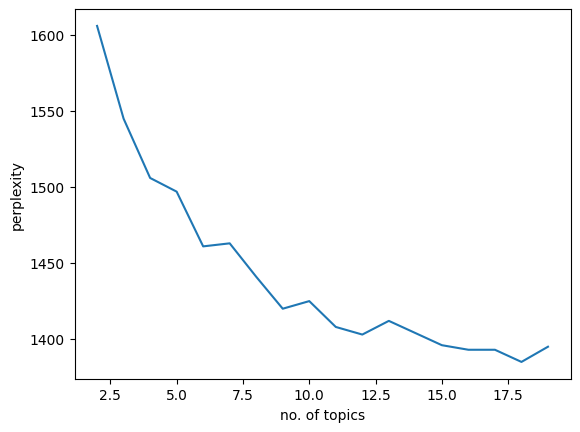

<Figure size 800x600 with 0 Axes>

In [8]:
######plotting the perplexity
import matplotlib.pyplot as plt
perplex= pd.read_csv('Qian_L_perplexities.csv', header=0)
y= perplex['perplexity']
x=perplex['topics']
plt.plot(x, y)
plt.xlabel('no. of topics',fontsize=10)
plt.ylabel('perplexity', fontsize=10)
plt.figure(figsize=(8, 6)) 

In [5]:
Meta= pd.read_csv('Qian_meta_L.csv', header=0, index_col=0)

In [6]:
my_obj.shape

(33694, 13831)

In [7]:
Meta.shape

(13831, 26)

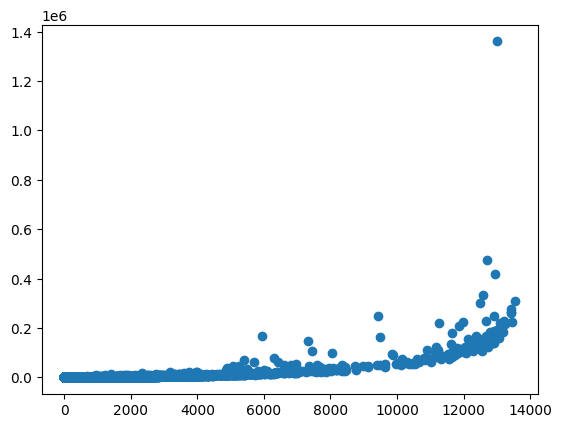

In [8]:
CountsAll= my_obj
plt.plot(CountsAll.astype(bool).sum(axis=1),CountsAll.sum(axis=1),'o')

In [9]:
countsAll= CountsAll
countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]

,BT1303_AAACCTGAGAGCCCAA,BT1303_AAACCTGAGGCATGGT,BT1303_AAACCTGAGTGCAAGC,BT1303_AAACCTGAGTGGTAAT,BT1303_AAACCTGAGTGGTAGC,BT1303_AAACCTGCAAGCGCTC,BT1303_AAACCTGCACATGACT,BT1303_AAACCTGCAGCAGTTT,BT1303_AAACCTGGTAAATGTG,BT1303_AAACCTGGTACAGTTC,...,scrSOL004_TTTGCGCTCGAACGGA,scrSOL004_TTTGGTTTCCTCAACC,scrSOL004_TTTGTCACAATCTGCA,scrSOL004_TTTGTCAGTACTTCTT,scrSOL004_TTTGTCAGTCACTTCC,scrSOL004_TTTGTCAGTCAGATAA,scrSOL004_TTTGTCAGTTCGCGAC,scrSOL004_TTTGTCATCACGAAGG,scrSOL004_TTTGTCATCCAACCAA,scrSOL004_TTTGTCATCGAACTGT
FO538757.2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
AP006222.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-206L10.9,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
RP11-54O7.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007325.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC004556.1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [10]:
countsFiltered = countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]


In [11]:
countsFiltered

,BT1303_AAACCTGAGAGCCCAA,BT1303_AAACCTGAGGCATGGT,BT1303_AAACCTGAGTGCAAGC,BT1303_AAACCTGAGTGGTAAT,BT1303_AAACCTGAGTGGTAGC,BT1303_AAACCTGCAAGCGCTC,BT1303_AAACCTGCACATGACT,BT1303_AAACCTGCAGCAGTTT,BT1303_AAACCTGGTAAATGTG,BT1303_AAACCTGGTACAGTTC,...,scrSOL004_TTTGCGCTCGAACGGA,scrSOL004_TTTGGTTTCCTCAACC,scrSOL004_TTTGTCACAATCTGCA,scrSOL004_TTTGTCAGTACTTCTT,scrSOL004_TTTGTCAGTCACTTCC,scrSOL004_TTTGTCAGTCAGATAA,scrSOL004_TTTGTCAGTTCGCGAC,scrSOL004_TTTGTCATCACGAAGG,scrSOL004_TTTGTCATCCAACCAA,scrSOL004_TTTGTCATCGAACTGT
FO538757.2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
AP006222.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-206L10.9,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
RP11-54O7.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007325.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC004556.1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [12]:
p = re.compile("RPS|RPL|RP")
list(filter(p.match,countsFiltered.index.values))

['RP11-206L10.9',
 'RP11-54O7.1',
 'RP11-465B22.8',
 'RP11-345P4.9',
 'RPL22',
 'RP3-510D11.2',
 'RP11-108M9.4',
 'RP1-43E13.2',
 'RP4-594I10.3',
 'RPS6KA1',
 'RPA2',
 'RP5-1092A3.4',
 'RP11-268J15.5',
 'RP11-69E11.4',
 'RP1-39G22.7',
 'RP5-1198O20.4',
 'RP11-386I14.4',
 'RP11-486G15.2',
 'RPF1',
 'RP4-621F18.2',
 'RP4-665J23.1',
 'RPAP2',
 'RP4-639F20.1',
 'RP11-421L21.3',
 'RP5-1065J22.8',
 'RP11-14N7.2',
 'RP11-337C18.8',
 'RP11-495P10.1',
 'RPRD2',
 'RP11-126K1.6',
 'RP11-422P24.12',
 'RP11-307C12.12',
 'RP11-263K19.4',
 'RP1-79C4.4',
 'RP11-296O14.3',
 'RP11-134G8.5',
 'RP11-61J19.5',
 'RPS6KC1',
 'RP11-452F19.3',
 'RP11-285F7.2',
 'RP11-295G20.2',
 'RP5-862P8.2',
 'RP5-827C21.4',
 'RP11-488L18.10',
 'RP11-214N9.1',
 'RP11-95D17.1',
 'RP11-254F7.2',
 'RP11-373D23.3',
 'RP11-490M8.1',
 'RP11-89K21.1',
 'RP11-191L17.1',
 'RP11-554J4.1',
 'RP11-474G23.3',
 'RP11-301O19.1',
 'RPIA',
 'RP11-332H14.2',
 'RP13-1039J1.2',
 'RP11-803D5.4',
 'RP11-65I12.1',
 'RP11-141B14.1',
 'RP11-395A13.2

In [13]:
countsFiltered = countsFiltered.drop(list(filter(p.match,countsFiltered.index.values)),axis=0)

In [14]:
countsFiltered

,BT1303_AAACCTGAGAGCCCAA,BT1303_AAACCTGAGGCATGGT,BT1303_AAACCTGAGTGCAAGC,BT1303_AAACCTGAGTGGTAAT,BT1303_AAACCTGAGTGGTAGC,BT1303_AAACCTGCAAGCGCTC,BT1303_AAACCTGCACATGACT,BT1303_AAACCTGCAGCAGTTT,BT1303_AAACCTGGTAAATGTG,BT1303_AAACCTGGTACAGTTC,...,scrSOL004_TTTGCGCTCGAACGGA,scrSOL004_TTTGGTTTCCTCAACC,scrSOL004_TTTGTCACAATCTGCA,scrSOL004_TTTGTCAGTACTTCTT,scrSOL004_TTTGTCAGTCACTTCC,scrSOL004_TTTGTCAGTCAGATAA,scrSOL004_TTTGTCAGTTCGCGAC,scrSOL004_TTTGTCATCACGAAGG,scrSOL004_TTTGTCATCCAACCAA,scrSOL004_TTTGTCATCGAACTGT
FO538757.2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
AP006222.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
NOC2L,0,0,0,0,0,0,0,0,1,0,...,0,0,3,0,0,0,0,1,0,0
PLEKHN1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007325.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC004556.1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [15]:
referenceCells= Meta[Meta['neigb_class']=='Singlet']

In [16]:
Meta.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell', 'nGene', 'nUMI',
       'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType',
       'percent.mt', 'RNA_snn_res.0.3', 'seurat_clusters', 'celltype_main',
       'celltype_fine', 'ScType_cell', 'refined_celltype', 'new.clusters',
       'final_clusters', 'stage', 'OvC_Label', 'TissueType', 'neigb_class',
       'neigb_type', 'stage_class'],
      dtype='object')

In [17]:
referenceCells.head

<bound method NDFrame.head of                            orig.ident  nCount_RNA  nFeature_RNA   
BT1303_AAACCTGAGAGCCCAA        BT1303         951           208  \
BT1303_AAACCTGAGGCATGGT        BT1303         421           249   
BT1303_AAACCTGAGTGGTAAT        BT1303         409           259   
BT1303_AAACCTGCAAGCGCTC        BT1303         452           303   
BT1303_AAACCTGCACATGACT        BT1303         572           339   
...                               ...         ...           ...   
scrSOL004_TTTGTCAGTCACTTCC  scrSOL004        2129           868   
scrSOL004_TTTGTCAGTCAGATAA  scrSOL004        1572           843   
scrSOL004_TTTGTCAGTTCGCGAC  scrSOL004       10552          3107   
scrSOL004_TTTGTCATCCAACCAA  scrSOL004        8881          2508   
scrSOL004_TTTGTCATCGAACTGT  scrSOL004         617           439   

                                                  Cell  nGene   nUMI   
BT1303_AAACCTGAGAGCCCAA        BT1303_AAACCTGAGAGCCCAA    208    951  \
BT1303_AAACCTGAGGCATG

In [18]:
referenceCells.index = [i.replace("-",".") for i in referenceCells.index]
referenceCells.index

Index(['BT1303_AAACCTGAGAGCCCAA', 'BT1303_AAACCTGAGGCATGGT',
       'BT1303_AAACCTGAGTGGTAAT', 'BT1303_AAACCTGCAAGCGCTC',
       'BT1303_AAACCTGCACATGACT', 'BT1303_AAACCTGCAGCAGTTT',
       'BT1303_AAACCTGGTAAATGTG', 'BT1303_AAACCTGGTACAGTTC',
       'BT1303_AAACCTGGTTATGCGT', 'BT1303_AAACCTGTCAGGCCCA',
       ...
       'scrSOL004_TTTGCGCTCAACGGGA', 'scrSOL004_TTTGCGCTCCCTAATT',
       'scrSOL004_TTTGCGCTCGAACGGA', 'scrSOL004_TTTGTCACAATCTGCA',
       'scrSOL004_TTTGTCAGTACTTCTT', 'scrSOL004_TTTGTCAGTCACTTCC',
       'scrSOL004_TTTGTCAGTCAGATAA', 'scrSOL004_TTTGTCAGTTCGCGAC',
       'scrSOL004_TTTGTCATCCAACCAA', 'scrSOL004_TTTGTCATCGAACTGT'],
      dtype='object', length=11318)

In [19]:
countsFiltered.T

,FO538757.2,AP006222.2,SAMD11,NOC2L,PLEKHN1,HES4,ISG15,AGRN,C1orf159,TTLL10,...,MT-ATP8,MT-ND4L,MT-ND5,MT-ND6,AC011043.1,AL592183.1,AC007325.4,AL354822.1,AC004556.1,AC240274.1
BT1303_AAACCTGAGAGCCCAA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BT1303_AAACCTGAGGCATGGT,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
BT1303_AAACCTGAGTGCAAGC,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
BT1303_AAACCTGAGTGGTAAT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BT1303_AAACCTGAGTGGTAGC,0,0,1,0,0,0,0,0,0,0,...,1,1,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scrSOL004_TTTGTCAGTCAGATAA,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
scrSOL004_TTTGTCAGTTCGCGAC,0,0,0,0,0,0,0,1,0,0,...,0,1,1,3,1,0,0,0,1,0
scrSOL004_TTTGTCATCACGAAGG,0,0,0,1,0,0,0,0,0,0,...,0,1,10,5,0,0,0,0,0,0
scrSOL004_TTTGTCATCCAACCAA,0,0,0,0,0,0,0,0,1,0,...,0,0,7,3,0,0,0,0,0,0


In [20]:
referenceCounts= countsFiltered[referenceCells.index]

In [21]:
referenceCounts

,BT1303_AAACCTGAGAGCCCAA,BT1303_AAACCTGAGGCATGGT,BT1303_AAACCTGAGTGGTAAT,BT1303_AAACCTGCAAGCGCTC,BT1303_AAACCTGCACATGACT,BT1303_AAACCTGCAGCAGTTT,BT1303_AAACCTGGTAAATGTG,BT1303_AAACCTGGTACAGTTC,BT1303_AAACCTGGTTATGCGT,BT1303_AAACCTGTCAGGCCCA,...,scrSOL004_TTTGCGCTCAACGGGA,scrSOL004_TTTGCGCTCCCTAATT,scrSOL004_TTTGCGCTCGAACGGA,scrSOL004_TTTGTCACAATCTGCA,scrSOL004_TTTGTCAGTACTTCTT,scrSOL004_TTTGTCAGTCACTTCC,scrSOL004_TTTGTCAGTCAGATAA,scrSOL004_TTTGTCAGTTCGCGAC,scrSOL004_TTTGTCATCCAACCAA,scrSOL004_TTTGTCATCGAACTGT
FO538757.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
AP006222.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,0,0,0,1,0,0,0,...,0,0,0,3,0,0,0,0,0,0
PLEKHN1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007325.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC004556.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [22]:
doubletCells= Meta[Meta['neigb_class']=='Doublet']

In [23]:
doubletCells.head

<bound method NDFrame.head of                            orig.ident  nCount_RNA  nFeature_RNA   
BT1303_AAACCTGAGTGCAAGC        BT1303        2992          1433  \
BT1303_AAACCTGAGTGGTAGC        BT1303        2531          1063   
BT1303_AAAGTAGGTGATGTCT        BT1303        2015           900   
BT1303_AAAGTAGTCACGCATA        BT1303        4690          1671   
BT1303_AACCATGCACAAGCCC        BT1303       10373          3213   
...                               ...         ...           ...   
scrSOL004_TTTGCGCAGGGTGTGT  scrSOL004       11652          3584   
scrSOL004_TTTGCGCCATAGGATA  scrSOL004        7224          2547   
scrSOL004_TTTGCGCGTGTATGGG  scrSOL004        9397          2542   
scrSOL004_TTTGGTTTCCTCAACC  scrSOL004        7060          2668   
scrSOL004_TTTGTCATCACGAAGG  scrSOL004        7338          2582   

                                                  Cell  nGene   nUMI   
BT1303_AAACCTGAGTGCAAGC        BT1303_AAACCTGAGTGCAAGC   1433   2992  \
BT1303_AAACCTGAGTGGTA

In [24]:
doubletCells.index = [i.replace("-",".") for i in doubletCells.index]
doubletCells.index

Index(['BT1303_AAACCTGAGTGCAAGC', 'BT1303_AAACCTGAGTGGTAGC',
       'BT1303_AAAGTAGGTGATGTCT', 'BT1303_AAAGTAGTCACGCATA',
       'BT1303_AACCATGCACAAGCCC', 'BT1303_AACCATGGTCGCTTTC',
       'BT1303_AACCATGGTGCTTCTC', 'BT1303_AACCGCGAGTGAAGTT',
       'BT1303_AACGTTGTCCACTGGG', 'BT1303_AACTCTTGTACGCACC',
       ...
       'scrSOL004_TTTATGCTCCTGCTTG', 'scrSOL004_TTTCCTCAGGCTCATT',
       'scrSOL004_TTTCCTCTCGTCTGCT', 'scrSOL004_TTTCCTCTCTGTCTCG',
       'scrSOL004_TTTGCGCAGGACCACA', 'scrSOL004_TTTGCGCAGGGTGTGT',
       'scrSOL004_TTTGCGCCATAGGATA', 'scrSOL004_TTTGCGCGTGTATGGG',
       'scrSOL004_TTTGGTTTCCTCAACC', 'scrSOL004_TTTGTCATCACGAAGG'],
      dtype='object', length=2513)

In [25]:
doubletsCounts = countsFiltered[doubletCells.index]
doubletsCounts.shape

(12855, 2513)

In [26]:
#setting up LDA
singleCellLDA = VariationalLDA(K = 15,alpha = 1,eta=0.005,update_alpha=True)
singleCellLDA.load_data_sc(referenceCounts)
singleCellLDA.run_vb(n_its = 50,initialise=True)

Edited
Initialising
Starting iterations


/tmp/ipykernel_20772/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 25.42865527340897) (47.982372999191284 seconds, I think I'll finish in 39.9853108326594 minutes). Alpha: (5.9135752932768915,10.041364417361907)
Iteration 1 (change = 0.09981917354757049) (46.402846813201904 seconds, I think I'll finish in 37.89565823078156 minutes). Alpha: (7.647025829818701,13.063182182564391)
Iteration 2 (change = 0.09805824117271991) (44.69887733459473 seconds, I think I'll finish in 35.75910186767578 minutes). Alpha: (8.362841789646296,14.212679637211831)
Iteration 3 (change = 0.09509299714308056) (46.03378486633301 seconds, I think I'll finish in 36.05979814529419 minutes). Alpha: (8.614645619961893,14.543149863474756)
Iteration 4 (change = 0.0897948236071874) (44.667837381362915 seconds, I think I'll finish in 34.245341992378236 minutes). Alpha: (8.659417328836657,14.519707395332668)
Iteration 5 (change = 0.07901754223360075) (45.223891258239746 seconds, I think I'll finish in 33.91791844367981 minutes). Alpha: (8.616143291350884,14.3444396

In [27]:
topic_dict = pd.DataFrame(singleCellLDA.beta_matrix,index=None).to_dict(orient='index')

In [28]:
scLDA = VariationalLDA(corpus=singleCellLDA.corpus,K=20,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.0005,update_alpha=True, fixed_topics=topic_dict)

Object created with 11318 documents


In [29]:
wordTopic = pd.DataFrame(singleCellLDA.beta_matrix, columns=referenceCounts.index)

In [30]:
scLDA.load_data_sc(doubletsCounts)

Edited


In [31]:
scLDA.run_vb(n_its=100,initialise=True)

Initialising
Here
Starting iterations


/tmp/ipykernel_20772/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 25.907574910993233) (43.722042083740234 seconds, I think I'll finish in 72.87007013956706 minutes). Alpha: (0.843380138243707,28.588288180642824)
Iteration 1 (change = 3.3008728711136808) (39.17615485191345 seconds, I think I'll finish in 64.6406555056572 minutes). Alpha: (0.5765324810564075,24.0963964865852)
Iteration 2 (change = 2.251605470947193) (38.47600769996643 seconds, I think I'll finish in 62.84414590994517 minutes). Alpha: (0.46231748988942734,21.279112794227196)
Iteration 3 (change = 1.8884572628943364) (37.40419387817383 seconds, I think I'll finish in 60.47011343638102 minutes). Alpha: (0.3977736199683963,19.61000655834889)
Iteration 4 (change = 1.7055068674345275) (37.58327317237854 seconds, I think I'll finish in 60.13323707580567 minutes). Alpha: (0.35342157736298513,18.49024228080974)
Iteration 5 (change = 1.627964267413238) (37.98234581947327 seconds, I think I'll finish in 60.13871421416601 minutes). Alpha: (0.3189867274997214,17.63971298502801

In [32]:
scLDA.beta_matrix.shape

(35, 12855)

In [33]:
scLDA.get_expect_theta().shape

(2513, 35)

In [34]:
wordTopicNew = pd.DataFrame(scLDA.beta_matrix, columns=referenceCounts.index)


In [35]:
doubletsCounts.shape

(12855, 2513)

In [36]:

interesting_genes = ranking_genes(15,35,scLDA, doubletsCounts.index)

In [37]:
interesting_genes[interesting_genes[3]==18].sort_values(1,ascending=False)[0:20]

,0,1,2,3
6903,LGALS1,209,0.091949,[18]
1032,COL3A1,202,0.120525,[18]
5879,COL1A1,201,0.108531,[18]
1124,COL6A3,200,0.21322,[18]
5712,UBB,195,0.114102,[18]
2625,PCOLCE,194,0.153968,[18]
2720,RARRES2,190,0.113636,[18]
7026,COL6A1,187,0.13253,[18]
2535,AEBP1,183,0.152882,[18]
2753,CD99,183,0.111653,[18]


In [38]:
interesting_genes.to_csv('Qian_L_genes.csv', index=False)

In [250]:
#interesting_genes= pd.read_csv('B_Can_genes.csv', header=0)


In [39]:
#int_genes = interesting_genes.groupby(0).filter(lambda x: len(x)<10)
int_genes= interesting_genes


In [40]:
final_genes = []
for i in range(11,34):
    g = int_genes[int_genes[3]==i].sort_values([1],ascending=False)[0:20][0].values
    final_genes.append(list(g))

In [41]:
final_genes = [item for sublist in final_genes for item in sublist]

In [42]:
final_genes

['NEAT1',
 'YWHAZ',
 'TNFAIP2',
 'AHNAK',
 'XIST',
 'GTF2I',
 'ITGB8',
 'DDX17',
 'RBM39',
 'PNISR',
 'LPP',
 'CD81',
 'MACF1',
 'C1orf186',
 'ACTN4',
 'MT-ND5',
 'TMA7',
 'PABPN1',
 'N4BP2L2',
 'TTC14',
 'TIMP1',
 'SH3BGRL3',
 'TUBA1B',
 'LGALS1',
 'S100A16',
 'ANXA2',
 'IGFBP6',
 'LDHA',
 'TPM2',
 'S100A11',
 'ENO1',
 'TPI1',
 'SPARC',
 'TAGLN2',
 'CCDC80',
 'ARPC2',
 'EMP3',
 'CAV1',
 'NBL1',
 'CD99',
 'ZMAT3',
 'PTGDS',
 'RARRES2',
 'IGFBP7',
 'COL1A1',
 'HLA-B',
 'AEBP1',
 'COL6A2',
 'BGN',
 'NBL1',
 'FBLN1',
 'COL6A1',
 'DCN',
 'COL6A3',
 'IGKC',
 'SPARCL1',
 'APOE',
 'COL1A2',
 'COL3A1',
 'CDH11',
 'LGALS1',
 'COL3A1',
 'COL1A1',
 'COL6A3',
 'UBB',
 'PCOLCE',
 'RARRES2',
 'COL6A1',
 'AEBP1',
 'CD99',
 'SERPINF1',
 'COL1A2',
 'THY1',
 'CALD1',
 'CTSK',
 'NBL1',
 'COL5A2',
 'NNMT',
 'COL6A2',
 'CTHRC1',
 'CRYAB',
 'DDAH2',
 'EIF4A2',
 'VIM',
 'MTCH1',
 'EEF2',
 'EIF3H',
 'HSP90AB1',
 'CNBP',
 'COX7A2L',
 'C6orf48',
 'EIF3E',
 'SLC25A3',
 'VDAC2',
 'HIST3H2A',
 'RNPS1',
 'TSC22D1',

In [43]:
len(list(set(final_genes)))

278

In [44]:
final_genes= list(set(final_genes))

In [45]:
print(len(final_genes))
final_genes= pd.DataFrame(final_genes)
#final_genes.to_csv('B_Can_AllGenes.csv')

278


In [46]:
refC = referenceCounts.T.merge(referenceCells,left_index=True,right_index=True)
refC = refC.sort_values(by="seurat_clusters")
refC = refC.drop(referenceCells.columns, axis=1)
allCounts = pd.merge(refC.T,doubletsCounts,left_index=True,right_index=True)
colours = ['blue' if x in refC.index else "red" for x in allCounts.columns]
topicWords = pd.DataFrame(scLDA.beta_matrix,columns=allCounts.index)

In [47]:
from matplotlib.transforms import Bbox
sb.set(font_scale=9)
blue_ref = mpatches.Patch(color="blue", label="reference")
red_dbls = mpatches.Patch(color="red", label="doublets")
legend_TN = [blue_ref, red_dbls]
heatmapCV = sb.clustermap(np.log1p(allCounts.loc[["TNFSF10",
                                                  "FOS","IFI16","ITM2B","ITGB1"]]),row_cluster=False, col_cluster=False, 
               figsize=(80,80),robust=True,cmap='coolwarm',col_colors = colours)

heatmapCV.ax_heatmap.set_xticks([])
heatmapCV.ax_heatmap.set_yticklabels(heatmapCV.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 120)
heatmapCV.ax_heatmap.set_xlabel("Cells",fontsize=200)
heatmapCV.ax_heatmap.set_ylabel("Genes",fontsize=200)
l2 = heatmapCV.ax_heatmap.legend(loc='center right',bbox_to_anchor=(1.40,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")
heatmapCV.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
plt.show()


In [53]:
#plt.savefig("Qian_L.png",dpi=100,bbox_inches="tight")

<Figure size 640x480 with 0 Axes>